In [1]:
import os
import glob as glob
import matplotlib.pyplot as plt
import numpy as np
import requests
import cv2
import random

In [2]:
SEED = 42
np.random.seed(SEED)

In [3]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="gOCWNtgakwRZrR01nSWg")
project = rf.workspace("sketch2code-huuvc").project("dataset-final-project")
dataset = project.version(18).download("yolov5")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 KB 786.4 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 KB 9.3 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=1204c49ddc909c8880e04c1bca271818e02b892bfcce6d2789ef9df31acadce2
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.9
    Uninstalling pyparsing-3.0.9:
      Successfully uninstalled pyparsing-3.0.9
  Attempting uninstall: cycler
    Found existing installation: cycler 0.11.0
    Uninstalling cycler-0.11.0:
      Successfully uninstalled cycler-0.11.0


loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to DataSet-Final-Project-18 in yolov5pytorch:: 100%|██████████| 574/574 [00:00<00:00, 2364.39it/s]


In [4]:
!ls


datasets  sample_data


In [5]:
TRAIN = True
EPOCHS = 10

In [18]:
import yaml

with open('datasets/data.yaml', 'r') as f:
    data = yaml.safe_load(f)

class_names=data["names"]
class_names

['Button',
 'Carousel',
 'Check Box',
 'Heading',
 'Image',
 'Label',
 'Link',
 'Pagination',
 'Paragraph',
 'Password Box',
 'Radio Button',
 'Select',
 'Subheading',
 'Table',
 'Textarea',
 'Textbox']

In [19]:
#class_names = ['Button','Carousel','Check Box','Form','Heading','Image','Label','Link','Pagination','Paragraph','Password box','Radio Button','Select','Subheading','Table','Table data','Table head','Table row','Textarea','Textbox']
colors = np.random.uniform(0 , 255, size = (len(class_names) , 3))
print(colors[0])

[139.41112123  47.13788616 247.24408008]


In [20]:
def yolo2bbox(bboxes):
  xmin, ymin = bboxes[0]-bboxes[2]/2 , bboxes[1]-bboxes[3]/2
  xmax, ymax = bboxes[0]+bboxes[2]/2 , bboxes[1]+bboxes[3]/2
  return xmin , ymin, xmax, ymax

In [21]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin
        
        class_name = class_names[int(labels[box_num])]
        
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        ) 

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))
        
        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        # Text width and height
        tw, th = cv2.getTextSize(
            class_name, 
            0, fontScale=font_scale, thickness=font_thickness
        )[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image, 
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image, 
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [22]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()
    
    num_images = len(all_training_images)
    
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                bbox_list = bbox_string.split(' ')
                if len(bbox_list) == 5:
                  del bbox_list[0]
                x_c, y_c, w, h = bbox_list
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

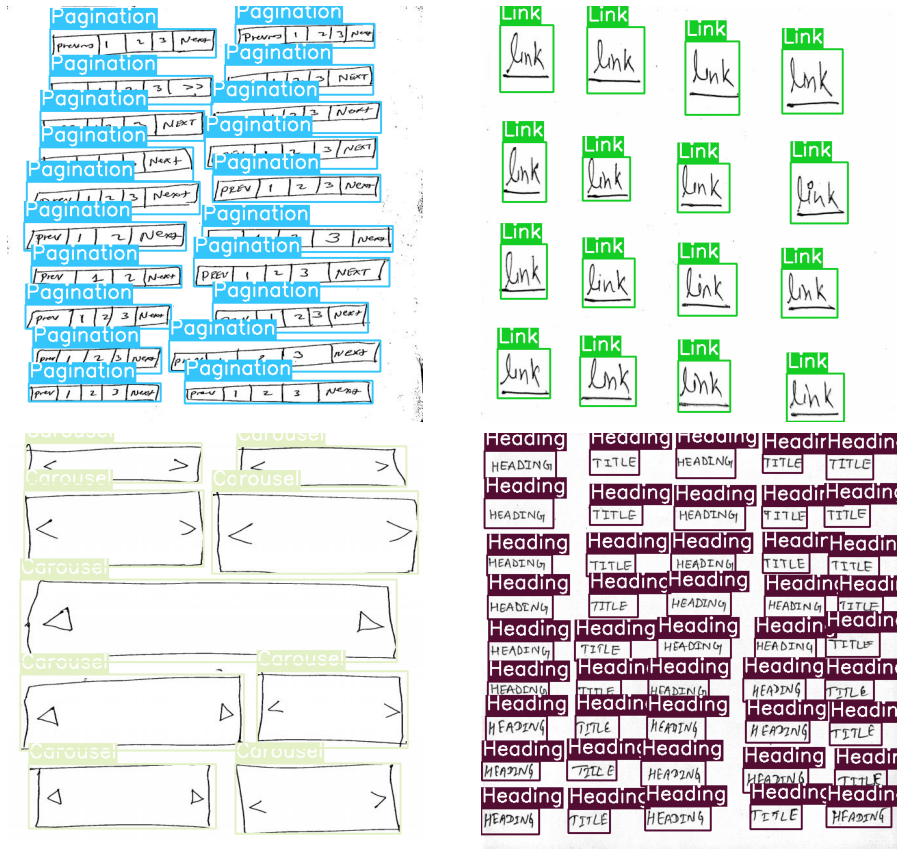

In [23]:
plot(
    image_paths='/content/datasets/train/images/*', 
    label_paths='/content/datasets/train/labels/*',
    num_samples=4,
)

In [24]:
def set_res_dir():
    # Directory to store results
    res_dir_count = len(glob.glob('runs/train/*'))
    print(f"Current number of result directories: {res_dir_count}")
    if TRAIN:
        RES_DIR = f"results_{res_dir_count+1}"
        print(RES_DIR)
    else:
        RES_DIR = f"results_{res_dir_count}"
    return RES_DIR

In [25]:
def monitor_tensorboard():
    %load_ext tensorboard
    %tensorboard --logdir runs/train

In [26]:
if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 15300, done.
remote: Total 15300 (delta 0), reused 0 (delta 0), pack-reused 15300
Receiving objects: 100% (15300/15300), 14.19 MiB | 23.02 MiB/s, done.
Resolving deltas: 100% (10496/10496), done.


In [27]:
%cd yolov5/
!pwd

/content/yolov5
/content/yolov5


In [28]:
from roboflow import Roboflow
rf = Roboflow(api_key="gOCWNtgakwRZrR01nSWg")
project = rf.workspace("sketch2code-huuvc").project("dataset-final-project")
dataset = project.version(18).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to DataSet-Final-Project-18 in yolov5pytorch:: 100%|██████████| 574/574 [00:00<00:00, 2687.05it/s]


In [29]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 6.3 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
cvxpy 1.2.3 requires setuptools<=64.0.2, but you have setuptools 67.6.0 which is incompatible.


In [30]:
!ls

benchmarks.py	 DataSet-Final-Project-18  models	     setup.cfg
CITATION.cff	 detect.py		   README.md	     train.py
classify	 export.py		   README.zh-CN.md   tutorial.ipynb
CONTRIBUTING.md  hubconf.py		   requirements.txt  utils
data		 LICENSE		   segment	     val.py


In [32]:
RES_DIR = set_res_dir()
if TRAIN:
    !python train.py --data /content/yolov5/DataSet-Final-Project-18/data.yaml --weights best.pt \
    --img 640 --epochs {EPOCHS} --batch-size 16 --name {RES_DIR}

Current number of result directories: 0
results_1
train: weights=best.pt, cfg=, data=/content/yolov5/DataSet-Final-Project-18/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=results_1, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-119-g5543b89 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj

In [34]:
from utils.plots import plot_results
plot_results('/content/yolov5/runs/train/results_1/results.csv')  # plot 'results.csv' as 'results.png'

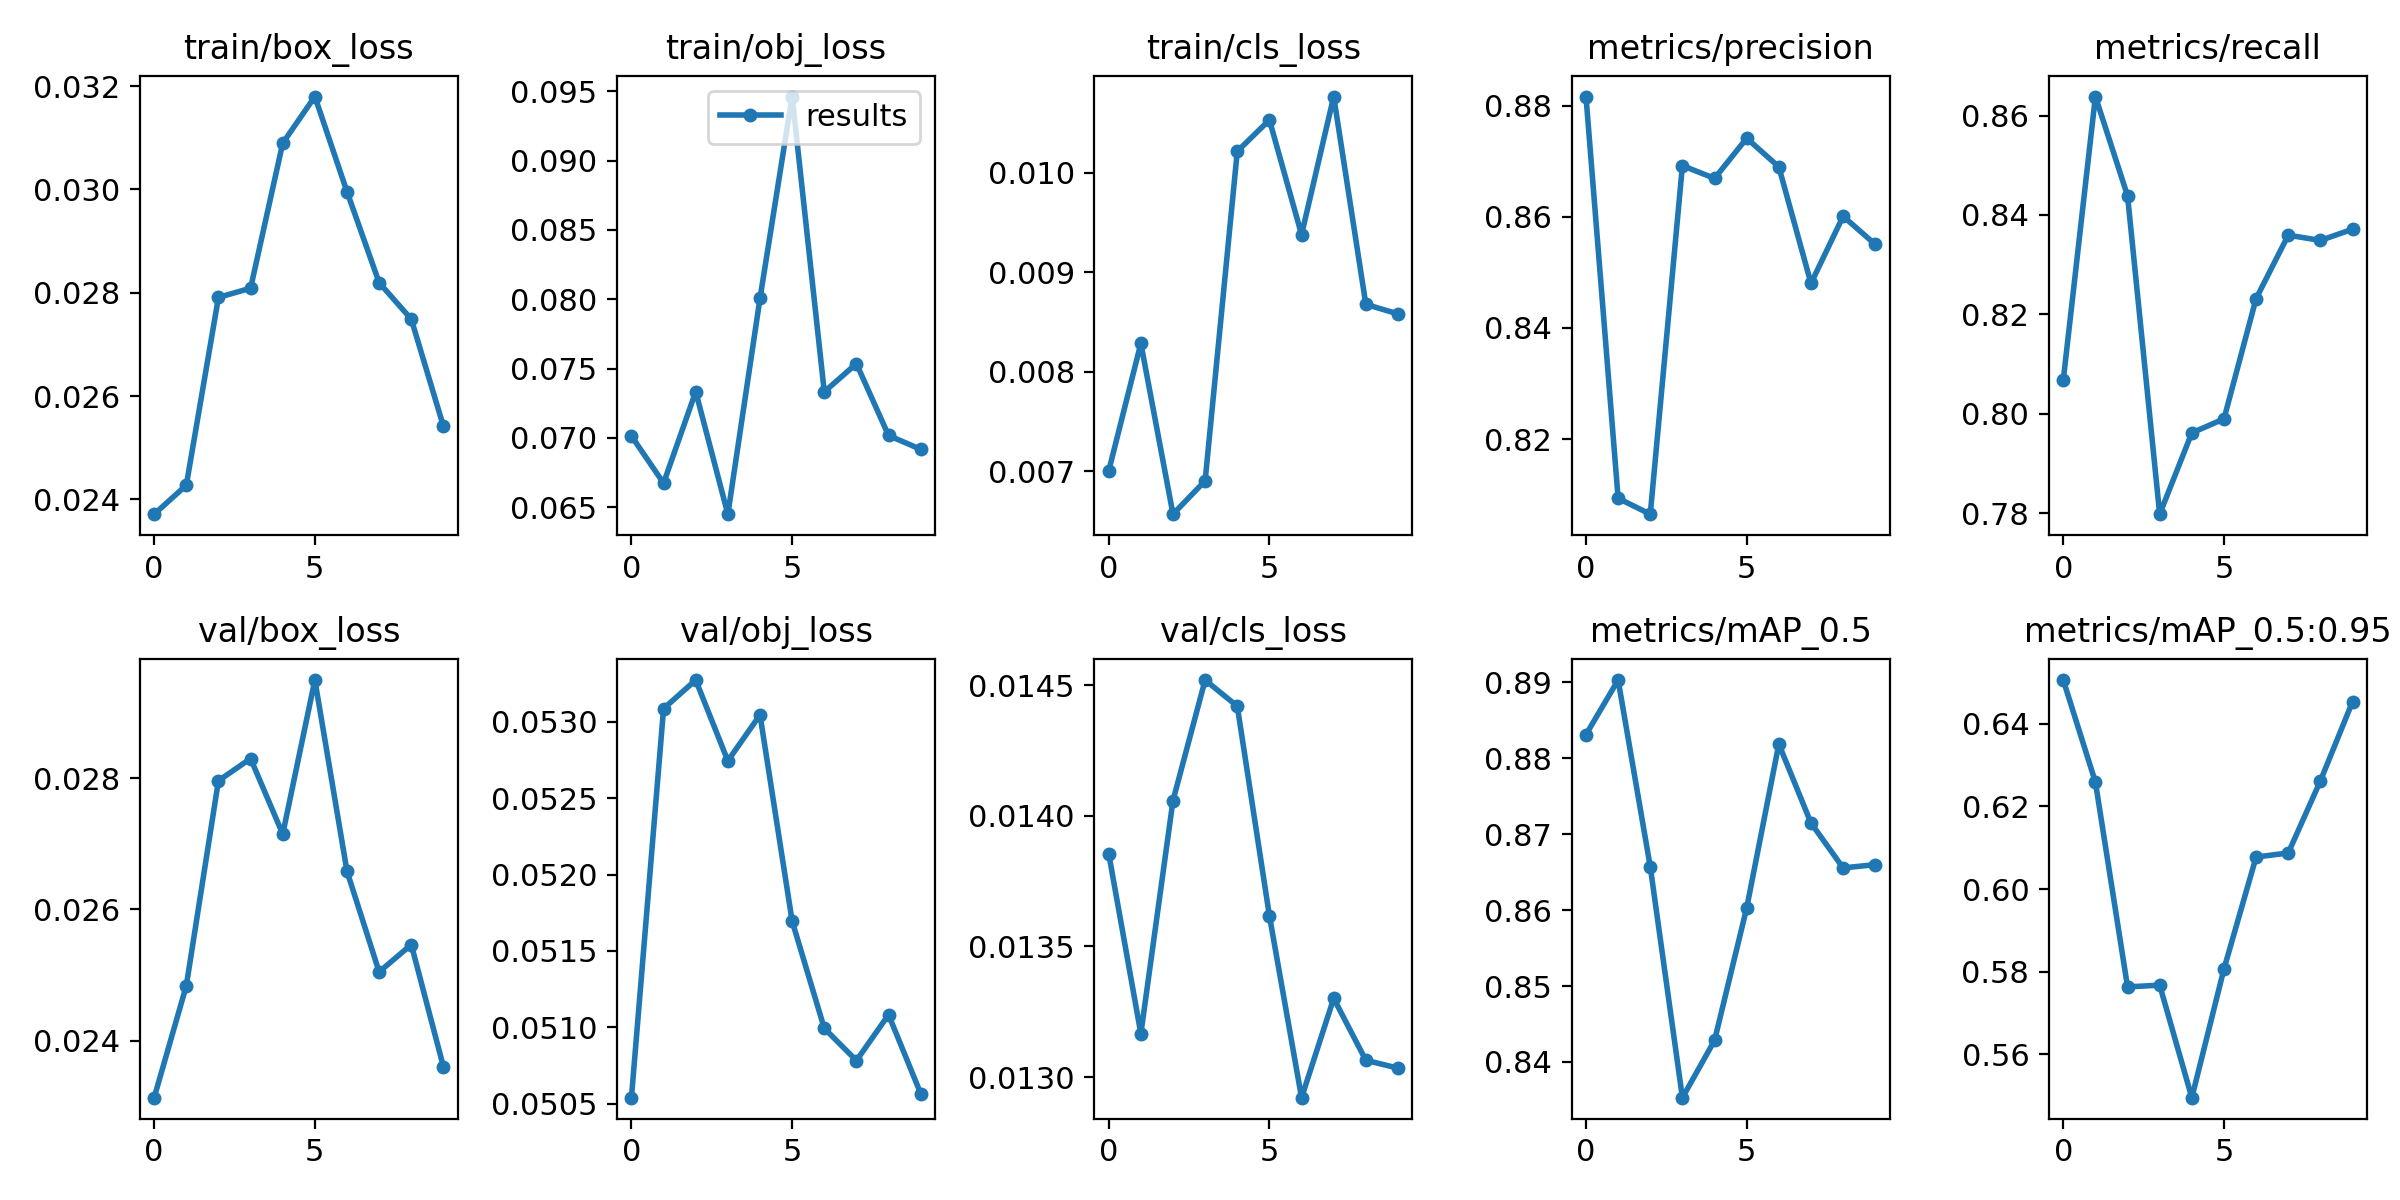

In [37]:
from PIL import Image
img = Image.open('/content/yolov5/runs/train/results_1/results.png')
img



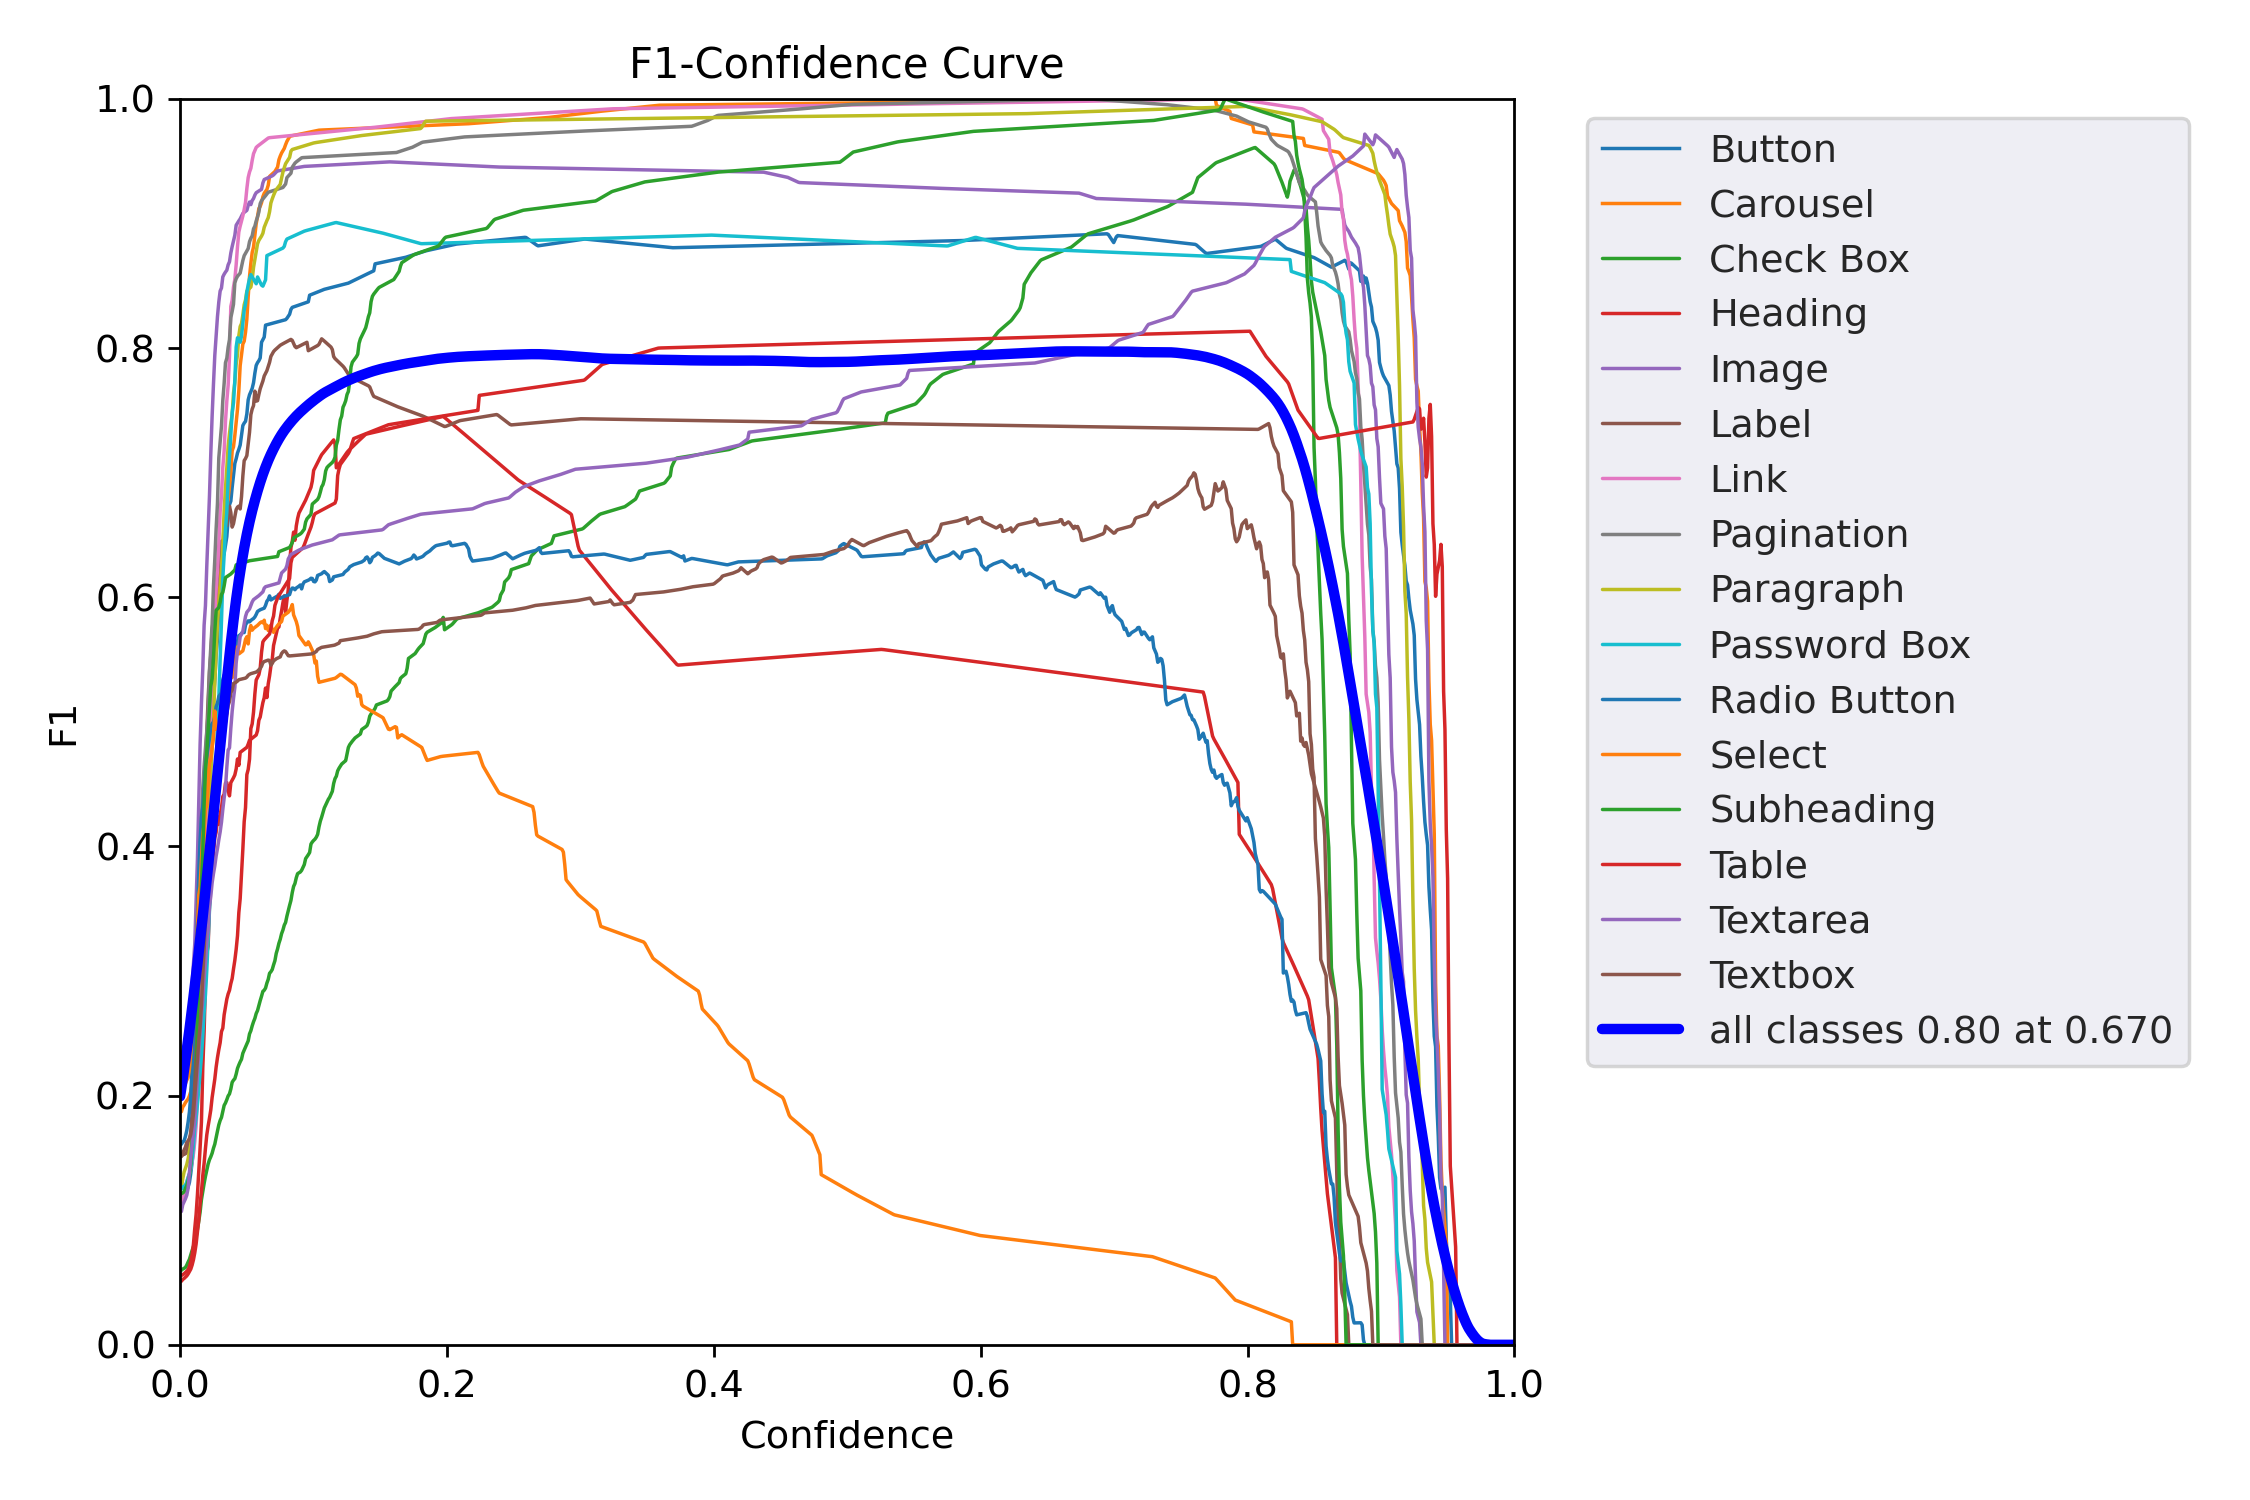

In [38]:
img = Image.open('/content/yolov5/runs/train/results_1/F1_curve.png')
img

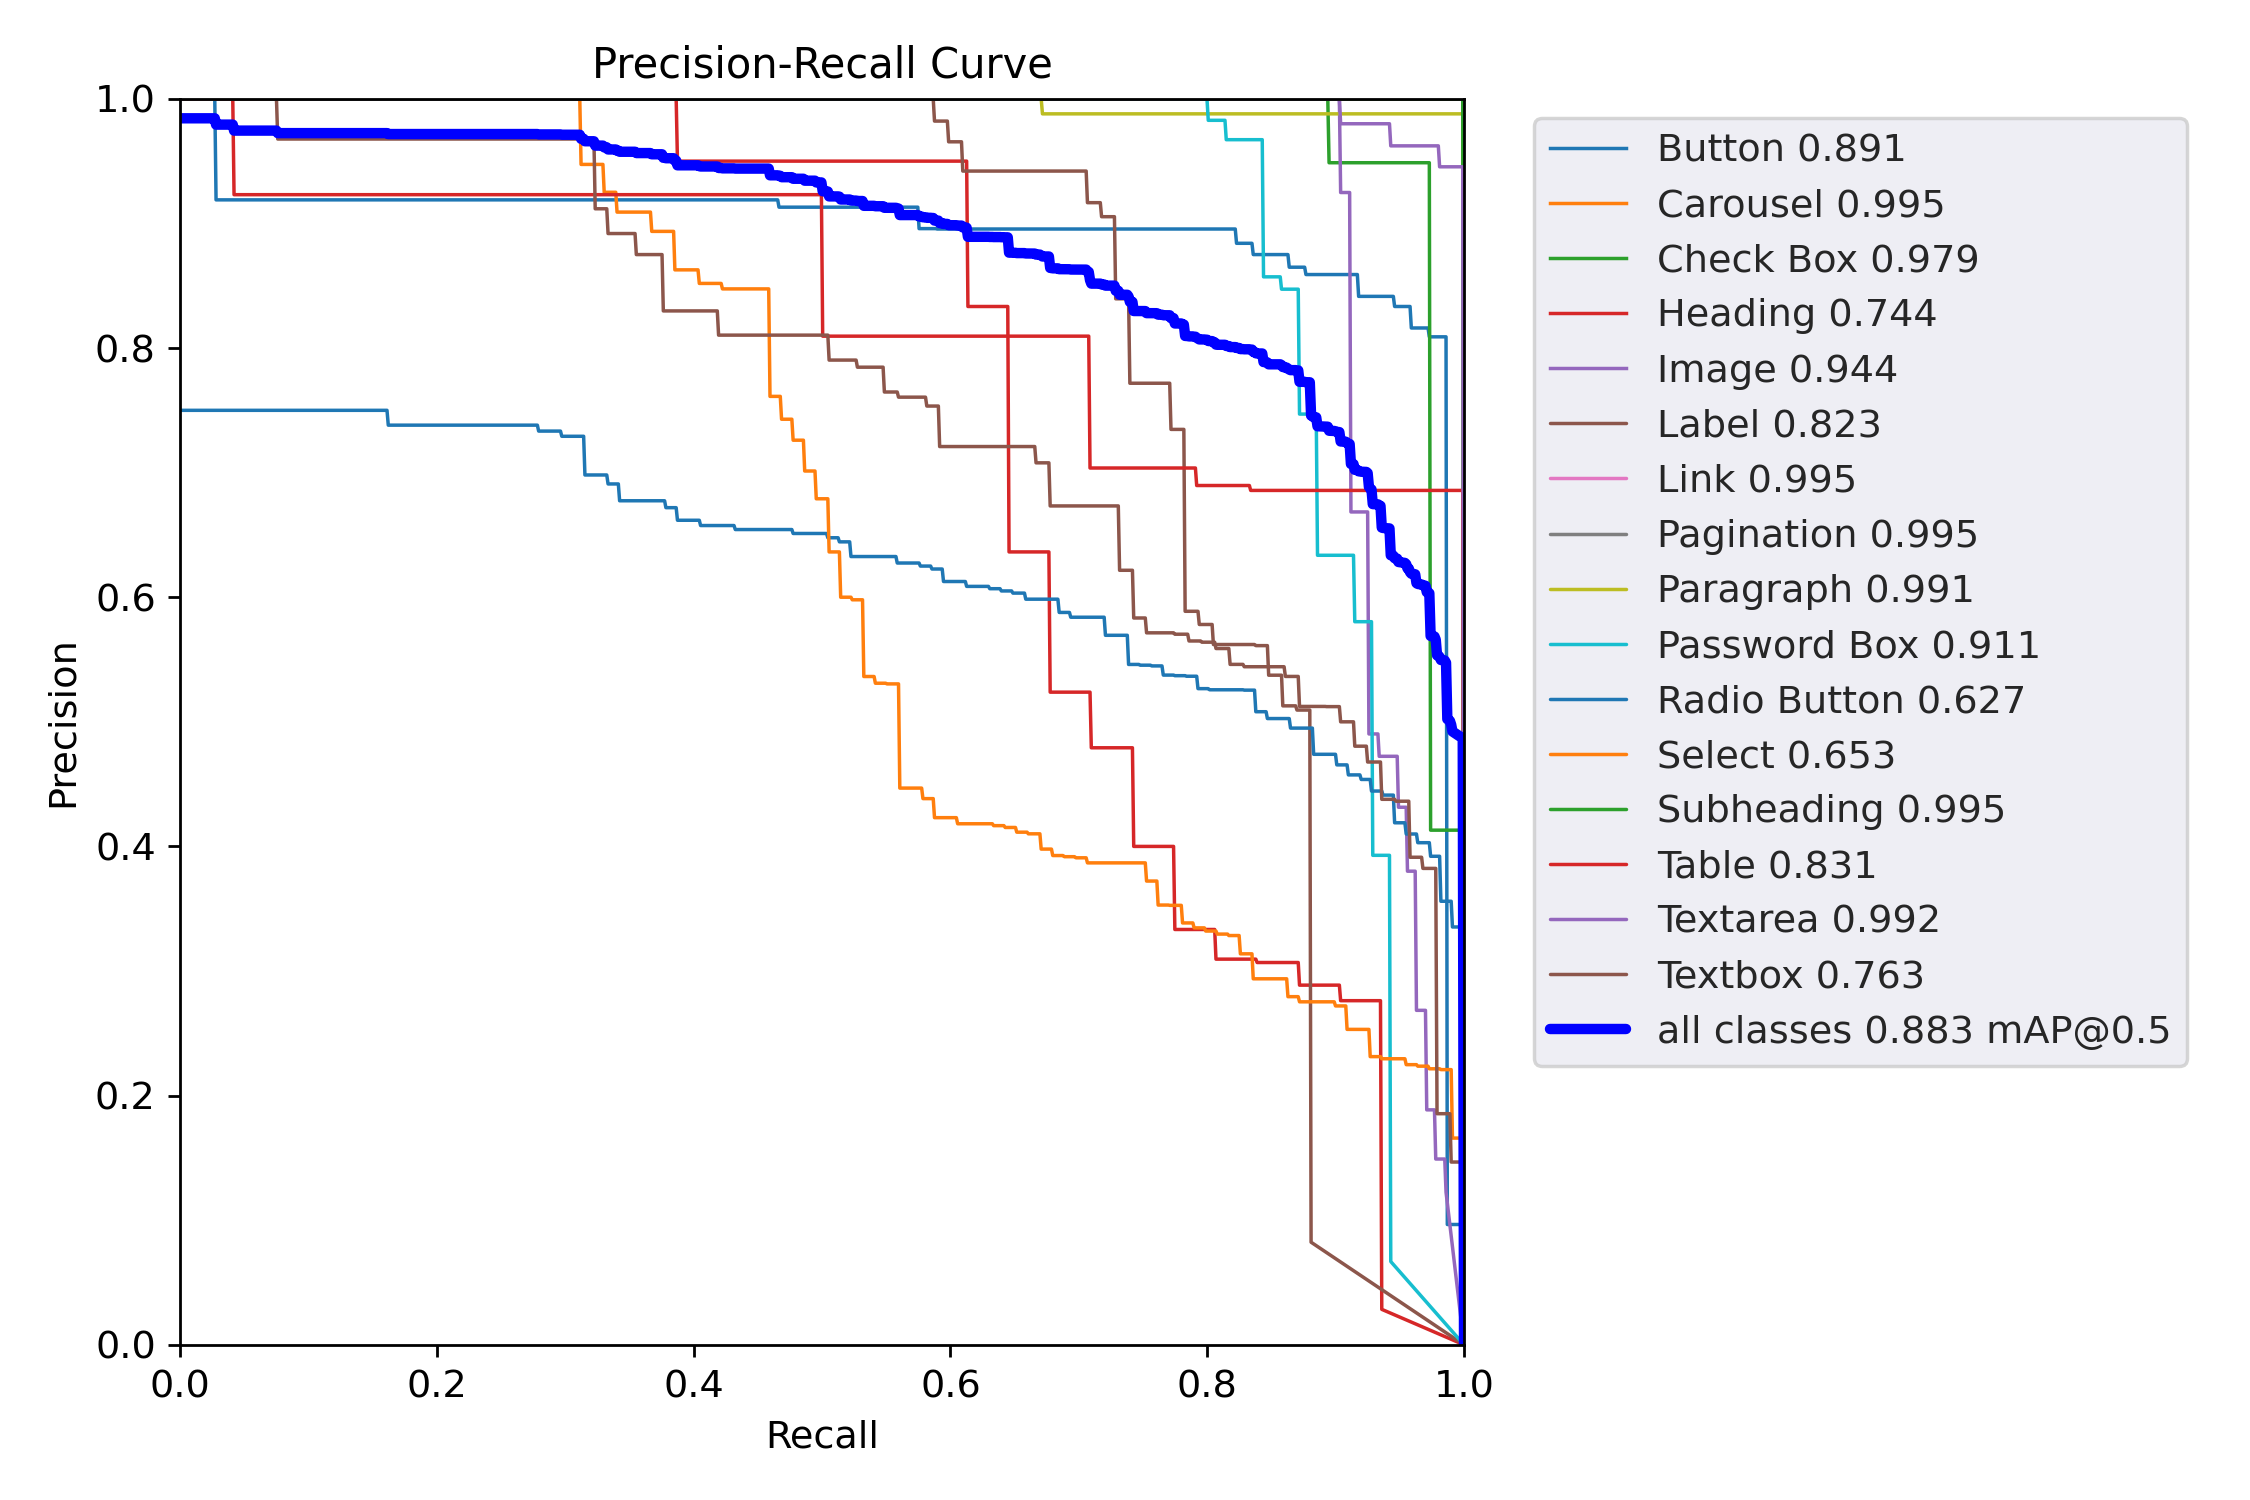

In [39]:
img = Image.open('/content/yolov5/runs/train/results_1/PR_curve.png')
img

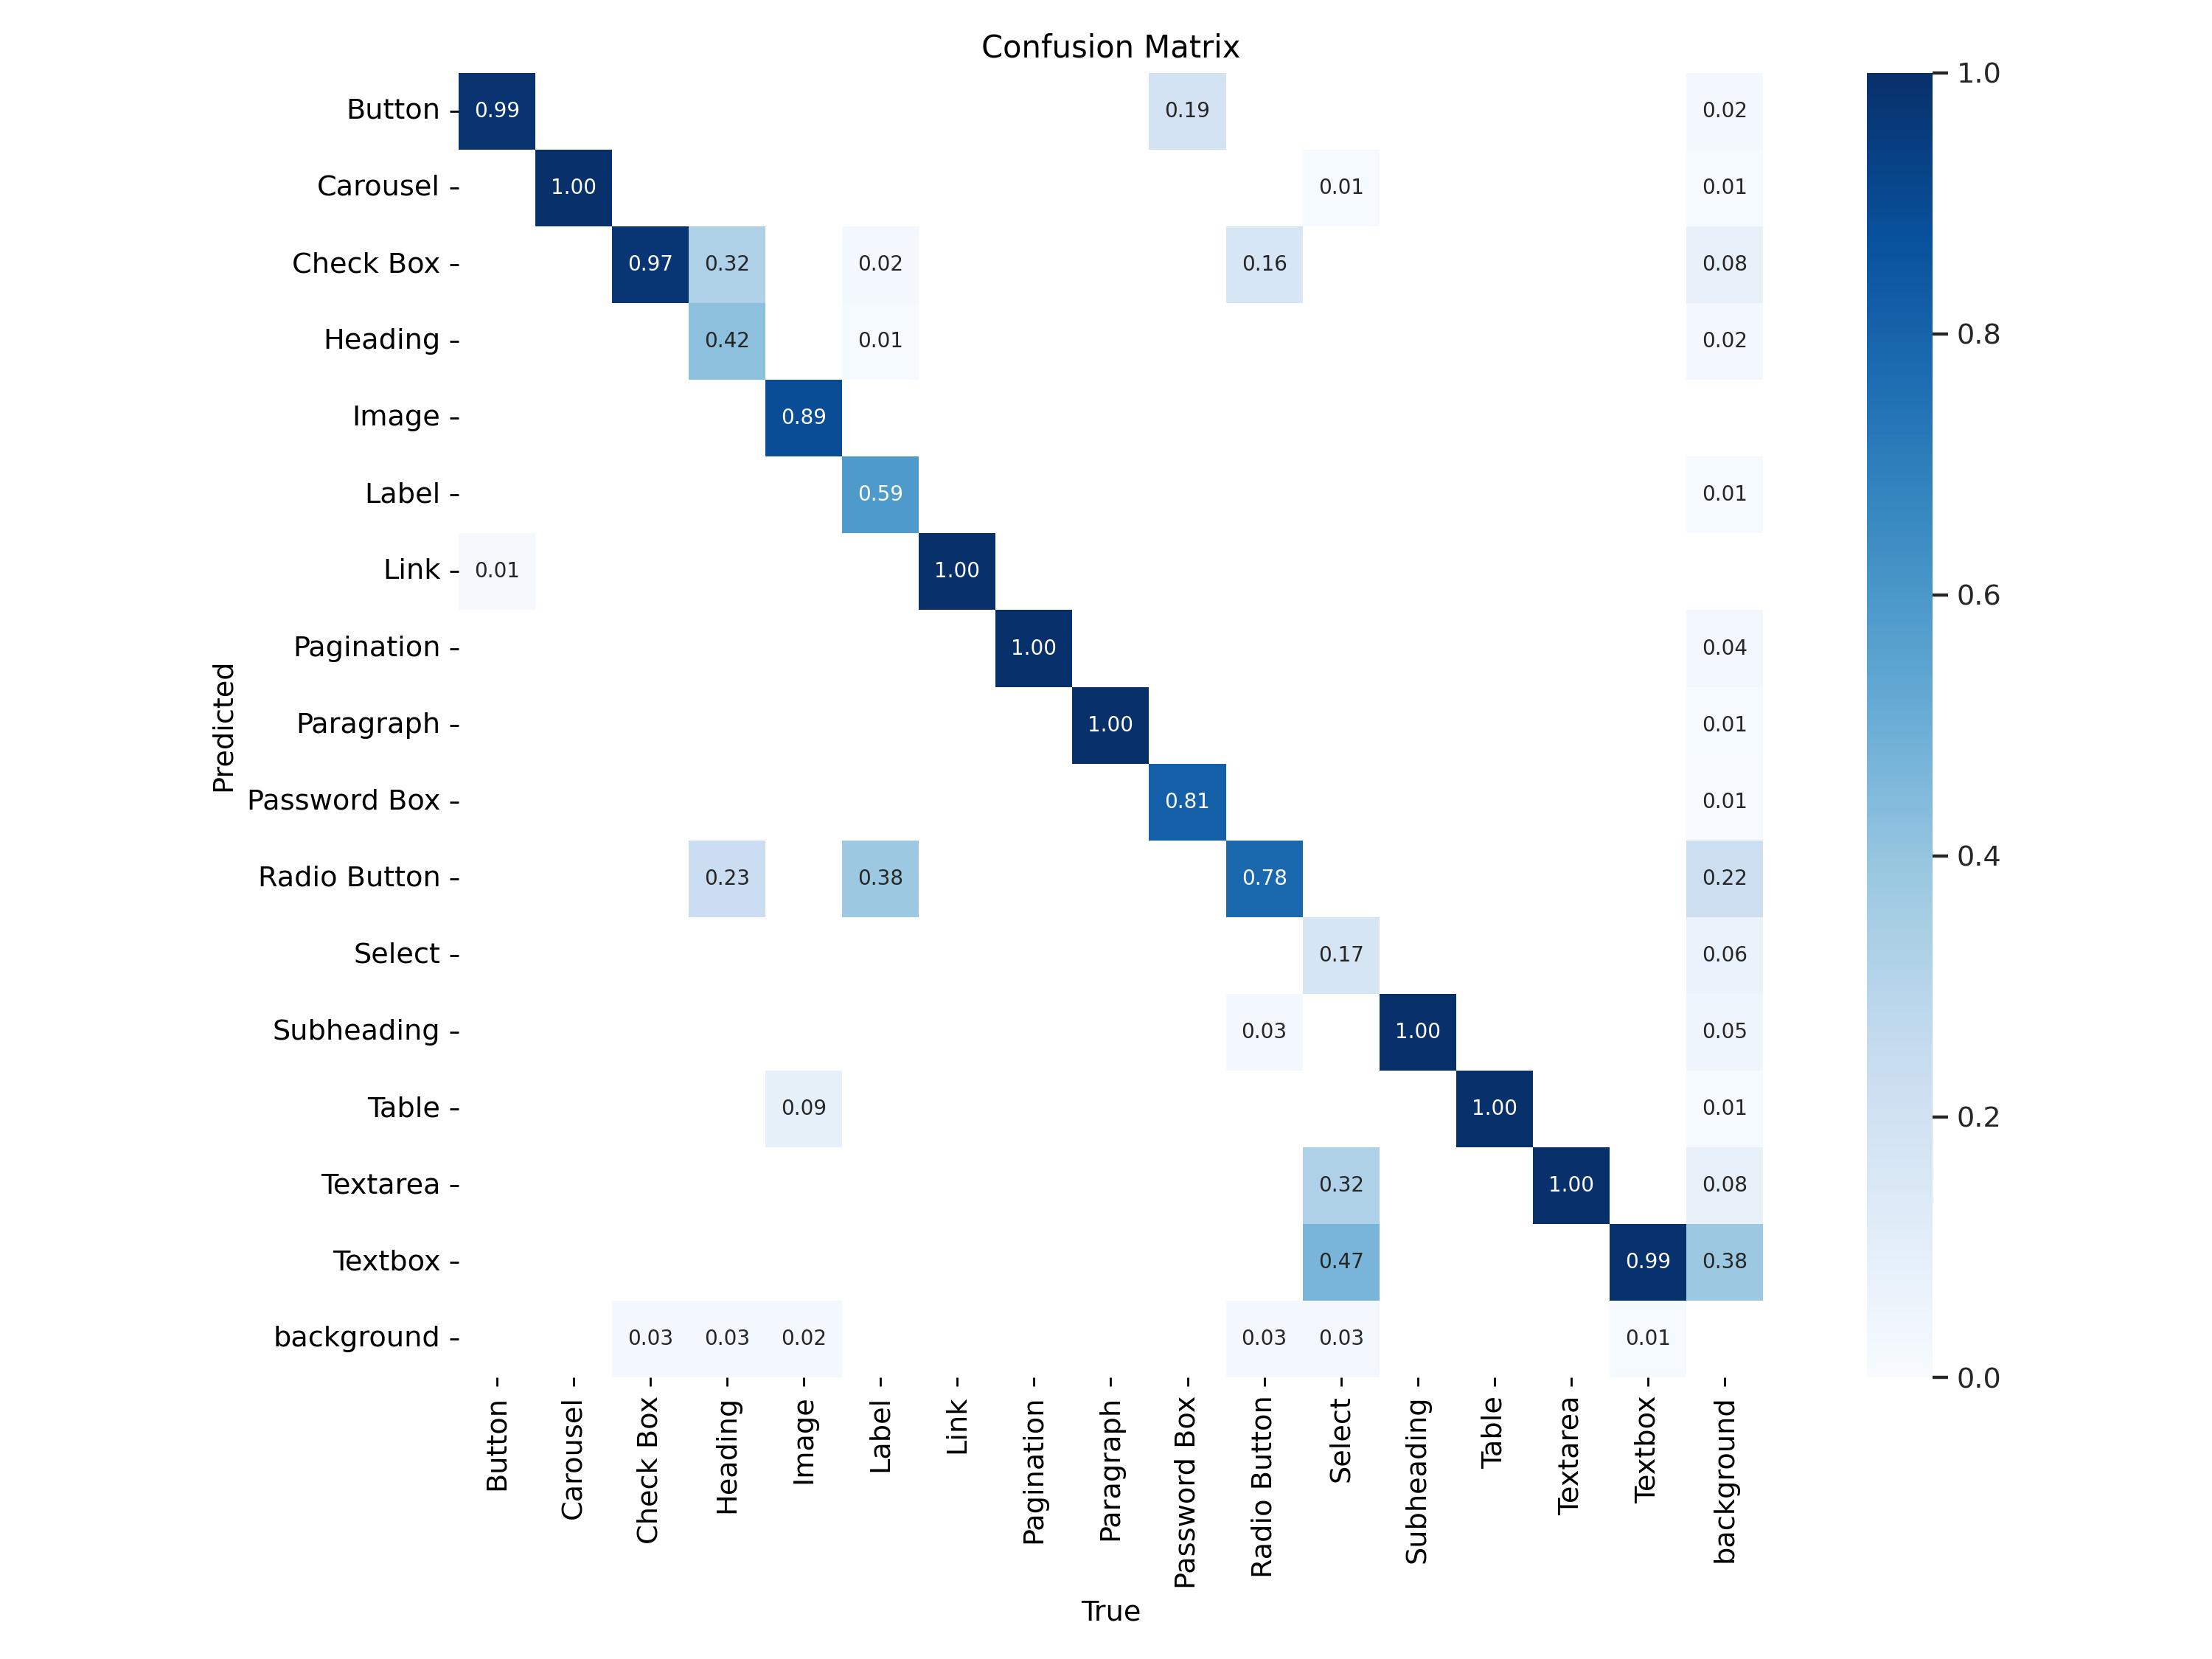

In [40]:
img = Image.open('/content/yolov5/runs/train/results_1/confusion_matrix.png')
img

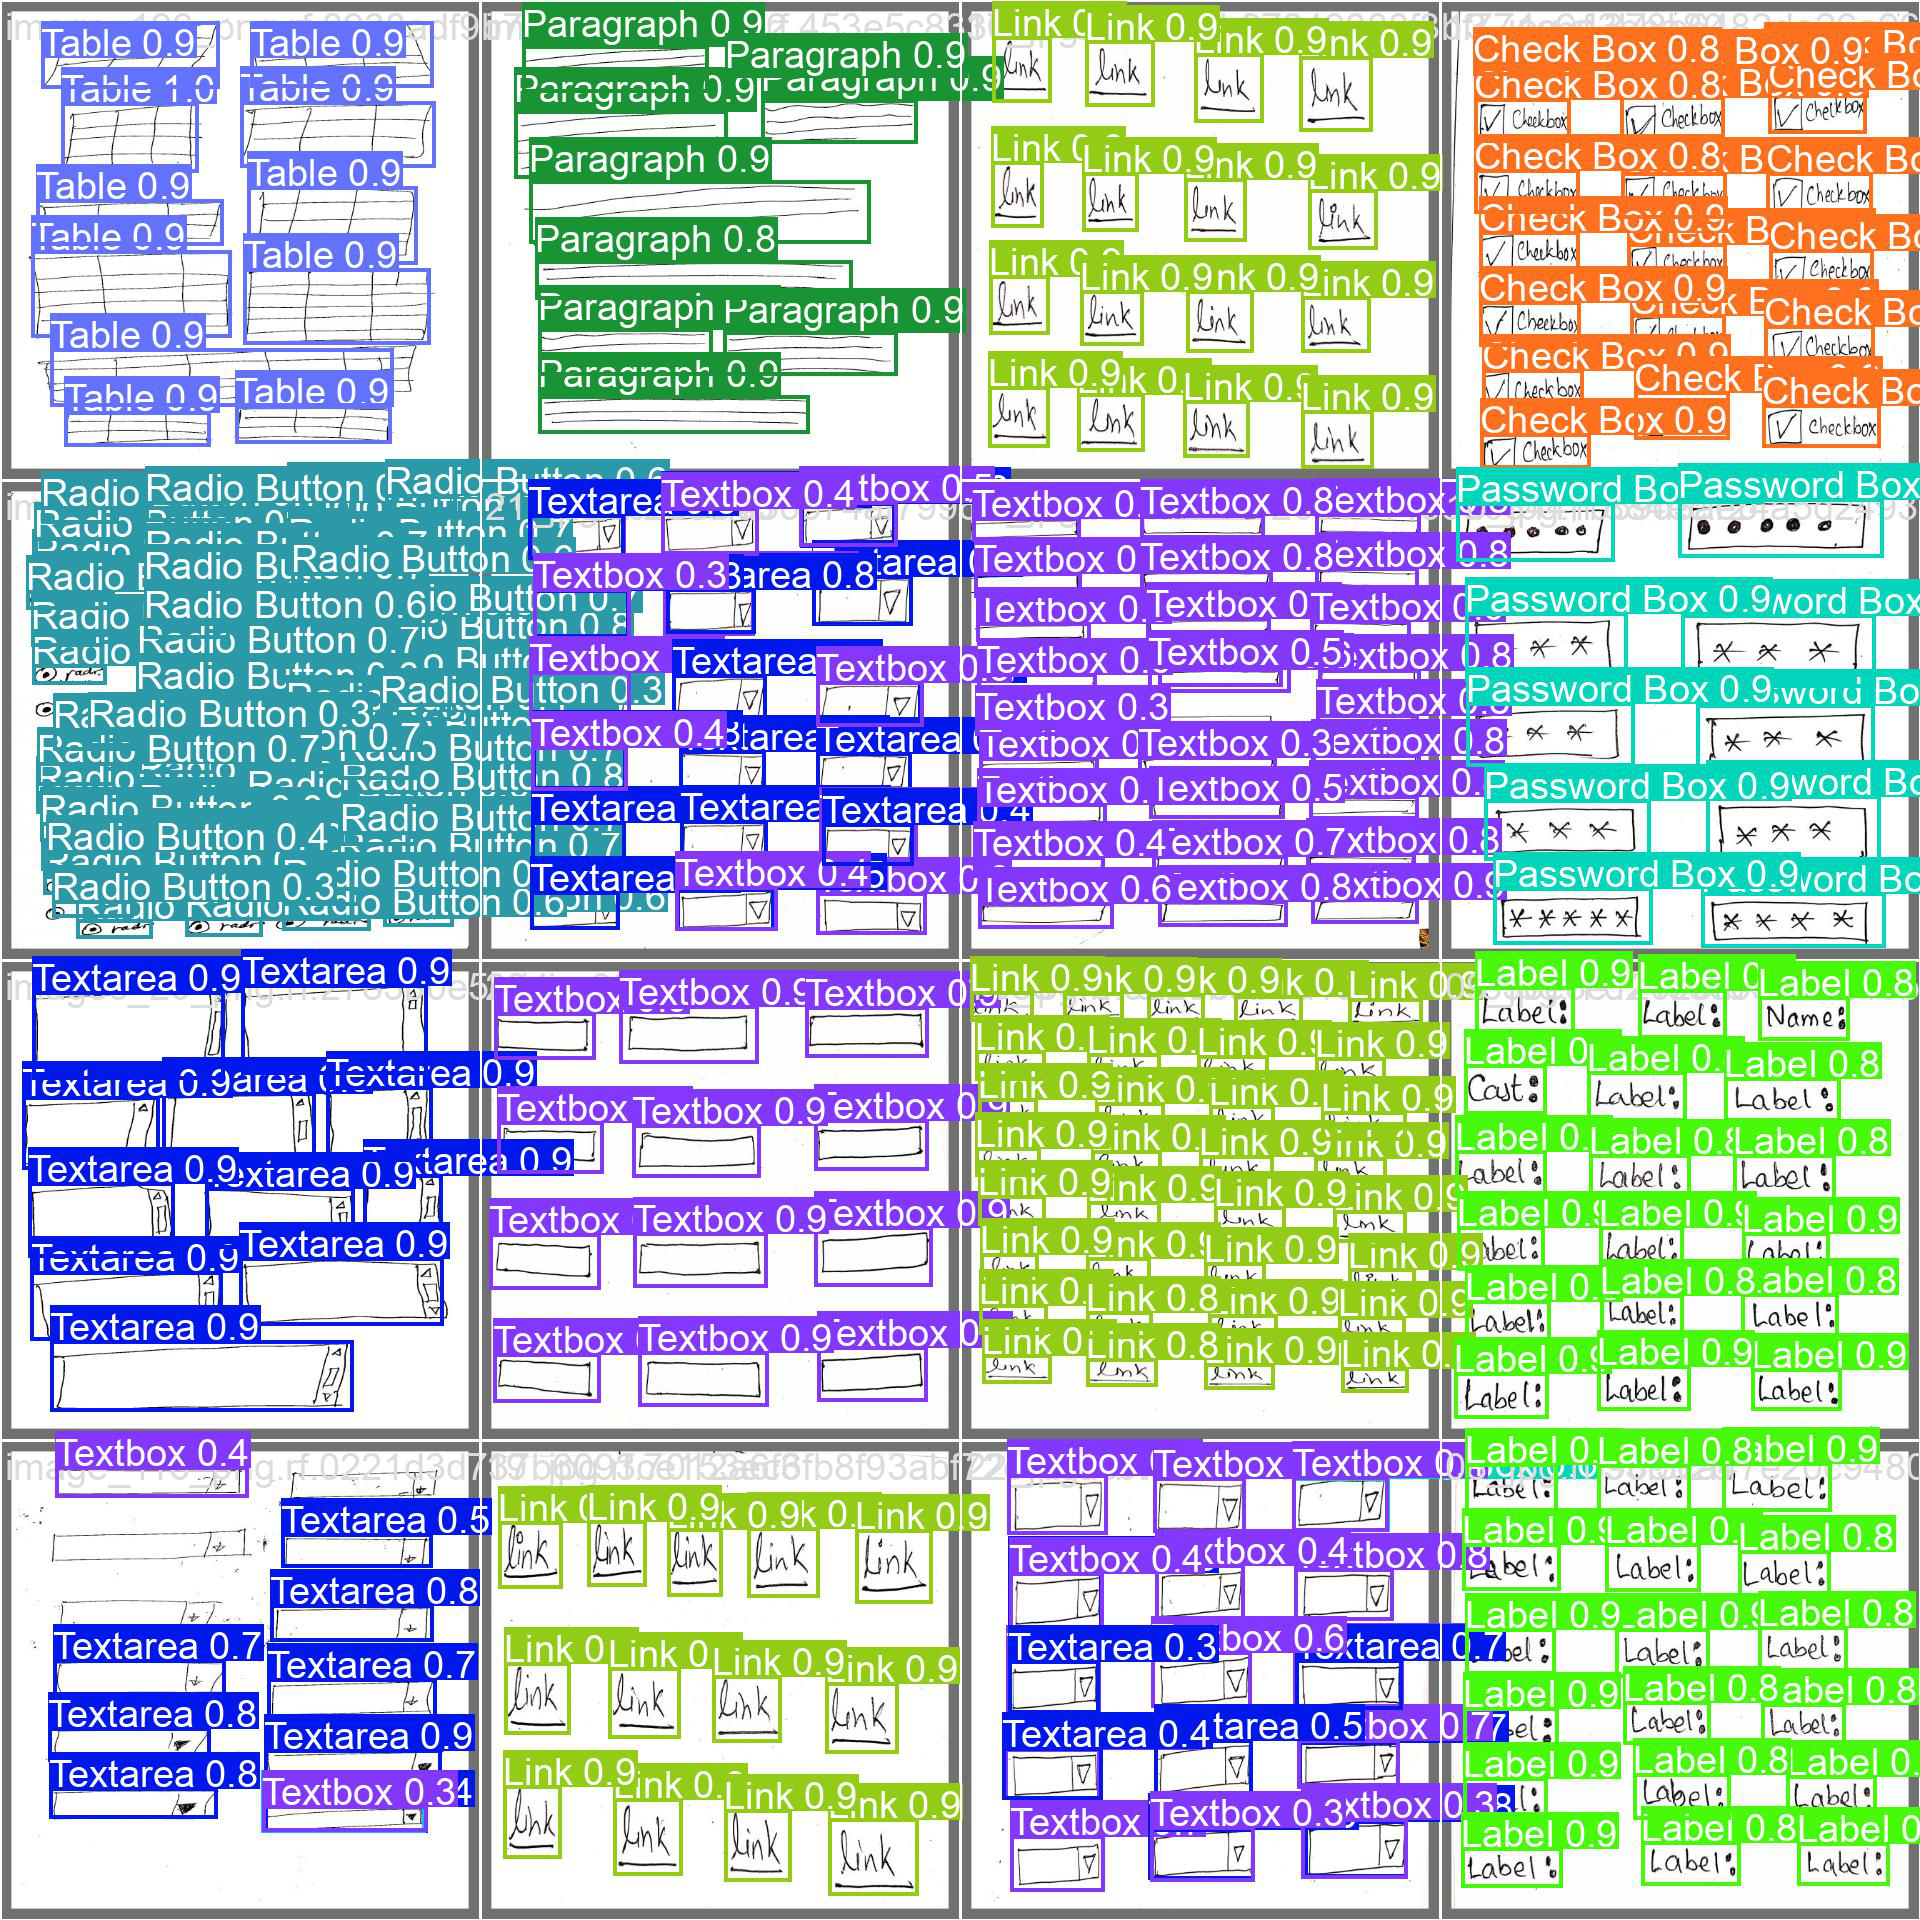

In [44]:
img = Image.open('/content/yolov5/runs/train/results_1/val_batch1_pred.jpg')
img